# HW_06 Бондаренко Алексей (bondaleksey@gmail.com)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import MinMaxScaler , StandardScaler

from sklearn.metrics import classification_report 
from datetime import datetime
from datetime import timedelta

from sklearn.model_selection import cross_val_score
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Цель проекта 
Цель проекта: построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю

План выполнения работы:
- Базовый EDA
- Генерация дополнительных признаков
- Baseline прогноз и проверка качества
- Построение различных моделей

# 1 Данные

## 1.1 Описание данных
 Признаки [набора данных](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

 - holiday (Categorical) -  US National holidays plus regional holiday, Minnesota State Fair
 - temp (Numeric) -  Average temp in kelvin
 - rain_1h (Numeric) -  Amount in mm of rain that occurred in the hour
 - snow_1h (Numeric) - Amount in mm of snow that occurred in the hour
 - clouds_all (Numeric) - Percentage of cloud cover
 - weather_main (Categorical) - Short textual description of the current weather
 - weather_description (Categorical) - Longer textual description of the current weather
 - date_time (DateTime) - Hour of the data collected in local CST time
 - traffic_volume (Numeric) - Hourly I-94 ATR 301 reported westbound traffic volume

In [2]:
data = pd.read_csv('data_ts/archive.csv.gz',compression='gzip', header=0, sep=',', quotechar='"',index_col=0)                  

In [3]:
data.head(5)

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
holiday,,,,,,,,
None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
data = data.reset_index();

## 1.2 Разведывательный анализ данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
data.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [7]:
def EDA(data):
    cols = data.columns
    print('Printing figures for columns:\n',cols)
    for item in cols:
        if item=='date_time':
            continue
        print("Look at column:", item)
        dt = data[item].dtype          
        if dt == 'int64'or dt == 'float64':        
            ax = data[item].plot(kind = 'hist', bins = 50)
            ax.set_xlabel(item)
            plt.show()
        elif dt == 'object':
            ax = data[item].value_counts().plot(kind = 'bar')
            ax.set_xlabel(item)
            plt.show()
        else:
            print(f'ooops, have problems with {item}')

Printing figures for columns:
 Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')
Look at column: holiday


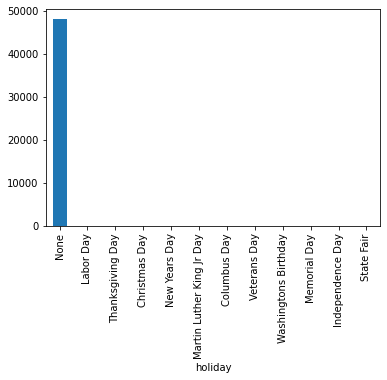

Look at column: temp


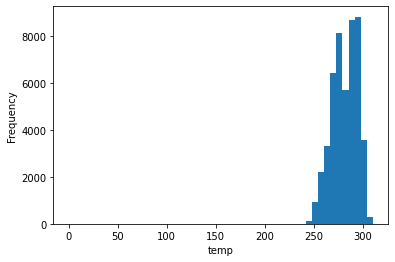

Look at column: rain_1h


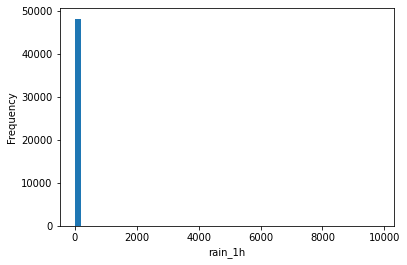

Look at column: snow_1h


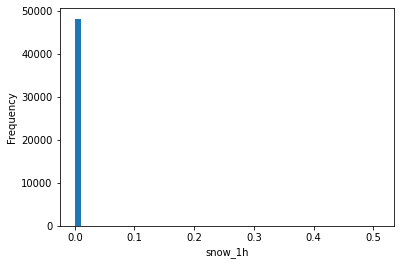

Look at column: clouds_all


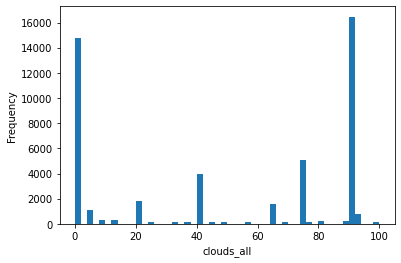

Look at column: weather_main


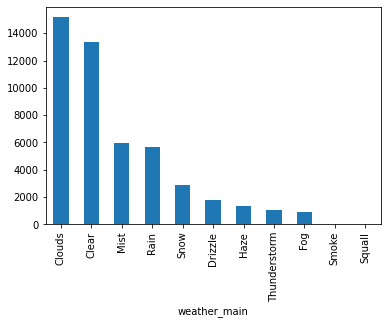

Look at column: weather_description


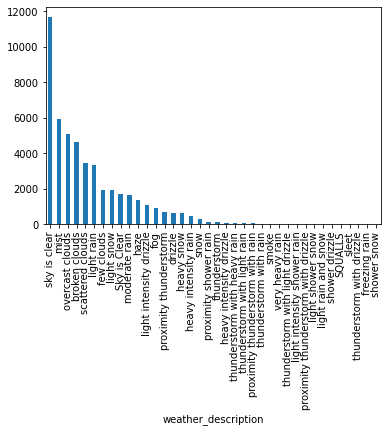

Look at column: traffic_volume


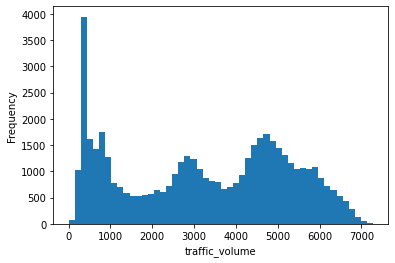

In [8]:
EDA(data)

Признаки, можно празники посмотреть и сравнить поведение в праздники и не в праздники... 
То есть праздники поставить как bool  1 

 ## 1.3 Преобразование данных и выбор признаков

### 1.3.1 Убираем дубликаты 

In [9]:
data.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'date_time', 'traffic_volume'],
      dtype='object')

In [10]:
wdata = data[['date_time','holiday','temp','traffic_volume']].copy()
wdata['date_time'] = pd.to_datetime(wdata['date_time'])
wdata = wdata.set_index('date_time')
wdata = wdata.drop_duplicates()

In [11]:
wdata.head()

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545
2012-10-02 10:00:00,None,289.36,4516
2012-10-02 11:00:00,None,289.58,4767
2012-10-02 12:00:00,None,290.13,5026
2012-10-02 13:00:00,None,291.14,4918


In [12]:
wdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40606 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40606 non-null  object 
 1   temp            40606 non-null  float64
 2   traffic_volume  40606 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


In [13]:
40606/(24*365)

4.635388127853881

### 1.3.2 Добавляем пропуски в записи данных по времени 

 А в информации данных указано, что период времени в данных почти 6 лет. Значит есть пропуски в данных.

In [14]:
print(wdata.loc['2012-11-05 13:00:00':'2012-11-05 21:00:00'])

                    holiday    temp  traffic_volume
date_time                                          
2012-11-05 13:00:00    None  278.47            4648
2012-11-05 14:00:00    None  278.71            4968
2012-11-05 16:00:00    None  280.56            6124
2012-11-05 17:00:00    None  280.56            6134
2012-11-05 18:00:00    None  279.26            4265
2012-11-05 20:00:00    None  280.56            2415
2012-11-05 21:00:00    None  280.56            1963


Как мы видим отсутствуют значения для 15 и 19 часов.

In [15]:
right_dates = pd.date_range(start='2012-10-02 09:00:00', end='2018-09-30 23:00:00', freq='H')
len(right_dates)

52551

In [16]:
# for ind, item in enumerate(right_dates):
    
#     if ind >10000:
#         break
#     if ind %(24*15)==0:
#         print("month = ",item.month)

Создадим пустой датафрейм с правильной индексацией по времени и потом объединим его с предварительно обработанными данными.

In [17]:
# wdata['date_time'] = pd.to_datetime(wdata['date_time'])

In [18]:
my_df = pd.DataFrame({'date_time': right_dates}).set_index('date_time')
my_df.head(3)

""
date_time
2012-10-02 09:00:00
2012-10-02 10:00:00
2012-10-02 11:00:00


In [19]:
print(type(my_df.index[1]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [20]:
print((my_df.index[1]-my_df.index[0]))

0 days 01:00:00


In [21]:
clean_data = my_df.join(wdata)
clean_data.head(3)

,holiday,temp,traffic_volume
date_time,,,
2012-10-02 09:00:00,None,288.28,5545.0
2012-10-02 10:00:00,None,289.36,4516.0
2012-10-02 11:00:00,None,289.58,4767.0


In [22]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52629 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40606 non-null  object 
 1   temp            40606 non-null  float64
 2   traffic_volume  40606 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


Число строчек в полученном DataFrame 52629, а число дат в нужном диапазоне = 52551.

In [23]:
(629-551)

78

### 1.3.3 Исправляем двойные значения в данных температуры

In [24]:
dupl = clean_data.index.duplicated(keep='last')
dupl.sum()

78

In [25]:
clean_data[clean_data.index.duplicated(keep=False)].head(6)

,holiday,temp,traffic_volume
date_time,,,
2012-11-04 01:00:00,None,275.60,730.0
2012-11-04 01:00:00,None,275.77,730.0
2014-01-03 20:00:00,None,267.97,2427.0
2014-01-03 20:00:00,None,268.88,2427.0
2014-01-09 16:00:00,None,265.73,6421.0
2014-01-09 16:00:00,None,266.47,6421.0


In [26]:
working_data = clean_data[~dupl].copy()

In [27]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            40528 non-null  float64
 2   traffic_volume  40528 non-null  float64
dtypes: float64(2), object(1)
memory usage: 1.6+ MB


In [28]:
month_number = list(map(lambda x: (x.month),right_dates))
is_weekend = list(map(lambda x: int((x.dayofweek>4)),right_dates))

In [29]:
working_data['is_holiday'] = working_data[working_data['holiday'].notna()]['holiday'].apply(lambda x: 0 if x == 'None' else 1)

In [30]:
# clean_data['is_weekend'] = pd.Series(is_weekend).values
working_data['is_weekend'] = is_weekend
working_data['month_number'] = month_number

In [31]:
working_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            40528 non-null  float64
 2   traffic_volume  40528 non-null  float64
 3   is_holiday      40528 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [32]:
in_data = working_data.interpolate(method='linear', axis=0).copy()

In [33]:
in_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 2.8+ MB


In [34]:
in_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,month_number
count,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000
mean,282.501583,3071.897557,0.001056,0.285894,6.521779
std,12.993132,1922.467889,0.032113,0.451843,3.448434
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,273.580000,1223.599161,0.000000,0.000000,4.000000
50%,286.420000,2897.000000,0.000000,0.000000,7.000000
75%,291.703441,4775.000000,0.000000,1.000000,10.000000
max,310.070000,7280.000000,1.000000,1.000000,12.000000


In [35]:
# Посмотрим на даты обозначенные как праздничные
# working_data['is_holiday'].sum()
# in_data[in_data['is_holiday']==1].head(60)

In [36]:
test_data = working_data.loc['2013-10-13 00:00:00':'2013-10-14 05:00:00'].copy()

In [37]:
in_data.loc['2013-10-13 22:00:00':'2013-10-14 05:00:00'].head(20)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number
date_time,,,,,,
2013-10-13 22:00:00,NaN,279.835714,1693.857143,0.0,1,10
2013-10-13 23:00:00,None,278.580000,1084.000000,0.0,1,10
2013-10-14 00:00:00,Columbus Day,277.720000,615.000000,1.0,0,10
2013-10-14 01:00:00,NaN,277.395000,453.000000,0.5,0,10
2013-10-14 02:00:00,None,277.070000,291.000000,0.0,0,10
2013-10-14 03:00:00,None,276.700000,388.000000,0.0,0,10
2013-10-14 04:00:00,NaN,277.145000,1541.000000,0.0,0,10
2013-10-14 05:00:00,None,277.590000,2694.000000,0.0,0,10


In [38]:
in_data['was_nan'] = working_data['traffic_volume'].isnull().astype(int)
in_data.head()

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2012-10-02 09:00:00,None,288.28,5545.0,0.0,0,10,0
2012-10-02 10:00:00,None,289.36,4516.0,0.0,0,10,0
2012-10-02 11:00:00,None,289.58,4767.0,0.0,0,10,0
2012-10-02 12:00:00,None,290.13,5026.0,0.0,0,10,0
2012-10-02 13:00:00,None,291.14,4918.0,0.0,0,10,0


In [39]:
in_data[in_data['is_holiday']==1].head(20)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2012-10-08,Columbus Day,273.08,455.0,1.0,0,10,0
2012-11-12,Veterans Day,288.12,1000.0,1.0,0,11,0
2012-11-22,Thanksgiving Day,278.54,919.0,1.0,0,11,0
2012-12-25,Christmas Day,264.40,803.0,1.0,0,12,0
2013-01-01,New Years Day,263.49,1439.0,1.0,0,1,0
2013-02-18,Washingtons Birthday,258.96,556.0,1.0,0,2,0
2013-05-27,Memorial Day,286.37,863.0,1.0,0,5,0
2013-07-04,Independence Day,290.08,1060.0,1.0,0,7,0
2013-08-22,State Fair,297.42,661.0,1.0,0,8,0


### Неожиданности 
Если посмотреть на даты праздничных дней, то видно что в некоторые годы праздничных дней значительно меньше, в 14 году всего 4 праздника и нет Рождества ... 

Так как в дата сете есть целые пропущенные дни, то возможно надо либо эти прощенные данные выкинуть, а оставшиеся использовать, либо пометить их как-то. Но ключевой вопрос, сколько у тебя интервалов прощенных данных и какова была их длинна? 


In [40]:
pd.unique(working_data['holiday'])

array(['None', nan, 'Columbus Day', 'Veterans Day', 'Thanksgiving Day',
       'Christmas Day', 'New Years Day', 'Washingtons Birthday',
       'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
       'Martin Luther King Jr Day'], dtype=object)

In [41]:
def add_holidays(df):
       holidays = ['Columbus Day', 'Veterans Day', 'Thanksgiving Day',
                   'Christmas Day', 'New Years Day', 'Washingtons Birthday',
                   'Memorial Day', 'Independence Day', 'State Fair', 'Labor Day',
                   'Martin Luther King Jr Day']
       out = df[df['holiday'].isin(holidays)]
       delta_hour = timedelta(hours=1)
       for day in out.index:
              for i in range(1,24,1):
                     df.loc[day+delta_hour*i,'is_holiday'] = 1       
       

In [42]:
add_holidays(in_data)

In [43]:
in_data['is_holiday'].sum()

1273.0

In [44]:
in_data.loc['2013-10-13 22:00:00':'2013-10-15 03:00:00'].head(50)

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2013-10-13 22:00:00,NaN,279.835714,1693.857143,0.0,1,10,1
2013-10-13 23:00:00,None,278.580000,1084.000000,0.0,1,10,0
2013-10-14 00:00:00,Columbus Day,277.720000,615.000000,1.0,0,10,0
2013-10-14 01:00:00,NaN,277.395000,453.000000,1.0,0,10,1
2013-10-14 02:00:00,None,277.070000,291.000000,1.0,0,10,0
2013-10-14 03:00:00,None,276.700000,388.000000,1.0,0,10,0
2013-10-14 04:00:00,NaN,277.145000,1541.000000,1.0,0,10,1
2013-10-14 05:00:00,None,277.590000,2694.000000,1.0,0,10,0
2013-10-14 06:00:00,None,277.990000,5729.000000,1.0,0,10,0


In [45]:
in_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52551 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         40528 non-null  object 
 1   temp            52551 non-null  float64
 2   traffic_volume  52551 non-null  float64
 3   is_holiday      52551 non-null  float64
 4   is_weekend      52551 non-null  int64  
 5   month_number    52551 non-null  int64  
 6   was_nan         52551 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(1)
memory usage: 5.0+ MB


In [46]:
in_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
count,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000,52551.000000
mean,282.501583,3071.897557,0.024224,0.285894,6.521779,0.228787
std,12.993132,1922.467889,0.153715,0.451843,3.448434,0.420056
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,273.580000,1223.599161,0.000000,0.000000,4.000000,0.000000
50%,286.420000,2897.000000,0.000000,0.000000,7.000000,0.000000
75%,291.703441,4775.000000,0.000000,1.000000,10.000000,0.000000
max,310.070000,7280.000000,1.000000,1.000000,12.000000,1.000000


In [47]:
print(pd.unique(in_data['is_holiday']))

[0.  1.  0.5]


In [48]:
in_data.loc[in_data[in_data['is_holiday']==0.5].index,'is_holiday']=0

### 1.3.4 Рассмотрим длины интервалов отсутствующих данных

In [49]:
def NAN_analysis(df):
    out_nans = {}
    delta_hour = timedelta(hours=1)
    out_data = df[df['traffic_volume'].isnull()].copy()
    out_data = out_data.reset_index()
    out_data['shifted'] = out_data['date_time'].shift(-1)  
    # print(out_data.head(10))
    start_nans = out_data.iloc[0,0]
    end_nans = None
    count_nans = 1
    for ind, row in out_data.iterrows():
        if row['shifted']-row['date_time'] > delta_hour:
            end_nans = row['date_time']
            out_nans[start_nans] = (count_nans,end_nans) 
            count_nans = 1
            start_nans = row['shifted']
            end_nans = None
        else:
            count_nans+=1
    return out_data, out_nans
    

In [50]:
out_data_all, out_nans_all = NAN_analysis(working_data)
out_data_all.head(5)

,date_time,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,shifted
0,2012-10-03 07:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-03 10:00:00
1,2012-10-03 10:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-03 11:00:00
2,2012-10-03 11:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-03 17:00:00
3,2012-10-03 17:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-05 02:00:00
4,2012-10-05 02:00:00,NaN,NaN,NaN,NaN,0,10,2012-10-05 04:00:00


In [51]:
for k,val in out_nans_all.items():
    if val[0] > 24:# and val[0]< 26:
    # stime = '2015-10-27 23:00:00'
    # dtime = (datetime.strptime(stime,"%Y-%m-%d %H:%M:%S"))                                        #  "%Y-%m-%d %H:%M:%S").timetuple()))
    # if k>dtime:        
        print(f'number of NAN points: {val[0]}, beg: {k}, end: {val[1]}') 

number of NAN points: 46, beg: 2013-08-31 01:00:00, end: 2013-09-01 22:00:00
number of NAN points: 29, beg: 2013-09-03 03:00:00, end: 2013-09-04 07:00:00
number of NAN points: 242, beg: 2013-10-27 02:00:00, end: 2013-11-06 03:00:00
number of NAN points: 116, beg: 2014-04-29 09:00:00, end: 2014-05-04 04:00:00
number of NAN points: 64, beg: 2014-07-27 17:00:00, end: 2014-07-30 08:00:00
number of NAN points: 32, beg: 2014-08-02 03:00:00, end: 2014-08-03 10:00:00
number of NAN points: 7386, beg: 2014-08-08 02:00:00, end: 2015-06-11 19:00:00
number of NAN points: 117, beg: 2015-06-14 21:00:00, end: 2015-06-19 17:00:00
number of NAN points: 29, beg: 2015-06-20 19:00:00, end: 2015-06-21 23:00:00
number of NAN points: 33, beg: 2015-06-22 19:00:00, end: 2015-06-24 03:00:00
number of NAN points: 92, beg: 2015-10-23 12:00:00, end: 2015-10-27 07:00:00


### 1.3.5 В заключении о пропусках в данных  
Далее будем рассматривать данные датируемые после 2015-10-27 07:00:00, так как до этого в датасете присутствуют значительные (более дня) пропуски. 

# 2 Генерация дополнительных признаков перед моделированием

In [52]:
in_data.tail()

,holiday,temp,traffic_volume,is_holiday,is_weekend,month_number,was_nan
date_time,,,,,,,
2018-09-30 19:00:00,None,283.45,3543.0,0.0,1,9,0
2018-09-30 20:00:00,None,282.76,2781.0,0.0,1,9,0
2018-09-30 21:00:00,None,282.73,2159.0,0.0,1,9,0
2018-09-30 22:00:00,None,282.09,1450.0,0.0,1,9,0
2018-09-30 23:00:00,None,282.12,954.0,0.0,1,9,0


In [53]:
short_data = in_data[in_data.index>'2015-10-27 23:00:00'].copy()
# short_data.drop(['holiday','is_weekday','month_number'],axis=1,inplace=True)
short_data.drop(['holiday','month_number'],axis=1,inplace=True)
# short_data.drop(['is_weekday'],axis=1,inplace=True)

### Изменения в фичах

In [54]:
# ohe_months= pd.get_dummies(short_data['month_number'],prefix = 'month')
# short_data = short_data.drop('month_number',axis=1)
# short_data = short_data.drop('was_nan',axis=1)
# short_data = short_data.join(ohe_months)

In [55]:
short_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25656 entries, 2015-10-28 00:00:00 to 2018-09-30 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            25656 non-null  float64
 1   traffic_volume  25656 non-null  float64
 2   is_holiday      25656 non-null  float64
 3   is_weekend      25656 non-null  int64  
 4   was_nan         25656 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.1 MB


Последний значительный интервал с отсутствующими данными, превышающими 1 день, произошел 23 октября 2015 года.
number of NAN points: 92, beg: 2015-10-23 12:00:00, end: 2015-10-27 07:00:00

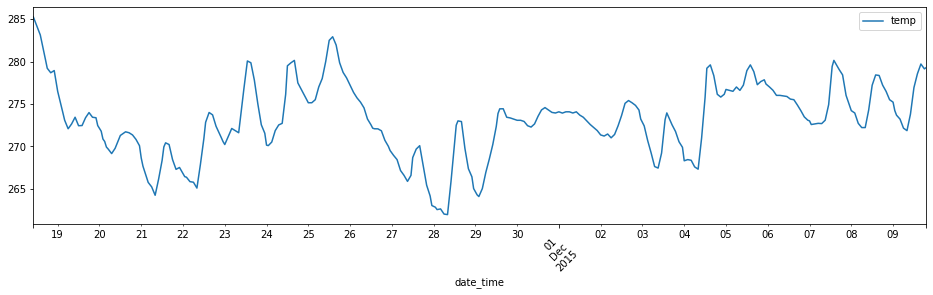

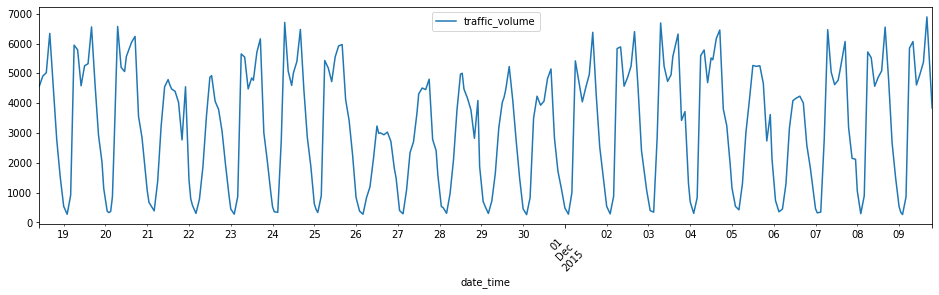

 h = 514, a = 514, b = 1028


In [56]:
def plot_data(df):
    N = 50
    h = int(np.ceil(len(df.index)/N))    
    # for i in range(N-1):
    a = h
    b = 2*h
    # a = 500
    # b = 520
    
    df.iloc[a:b,0].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    df.iloc[a:b,1].plot(figsize=(16,4))
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    print(f" h = {h}, a = {a}, b = {b}")

plot_data(short_data)

In [57]:
short_data.head()

,temp,traffic_volume,is_holiday,is_weekend,was_nan
date_time,,,,,
2015-10-28 00:00:00,281.430000,507.000000,0.0,0,0
2015-10-28 01:00:00,281.430000,339.000000,0.0,0,0
2015-10-28 02:00:00,281.383333,529.333333,0.0,0,1
2015-10-28 03:00:00,281.336667,719.666667,0.0,0,1
2015-10-28 04:00:00,281.290000,910.000000,0.0,0,0


In [58]:
short_data.describe()

,temp,traffic_volume,is_holiday,is_weekend,was_nan
count,25656.000000,25656.000000,25656.000000,25656.000000,25656.000000
mean,281.705907,3307.574992,0.028999,0.286249,0.067392
std,12.473522,1961.095335,0.167807,0.452016,0.250704
min,243.390000,0.000000,0.000000,0.000000,0.000000
25%,272.580000,1309.000000,0.000000,0.000000,0.000000
50%,282.690000,3503.000000,0.000000,0.000000,0.000000
75%,292.080000,4936.000000,0.000000,1.000000,0.000000
max,310.070000,7280.000000,1.000000,1.000000,1.000000


## 2.2 Простые модели без данных о времени дня

In [59]:
def create_lags(df, series_columns, start_lag, end_lag):
    data = df.copy()
    for c in series_columns:
        for i in range(start_lag, end_lag):
            data["lag_{}_{}".format(c, i)] = data[c].shift(i)
    return data


def timeseries_train_test_split(y, X=None, test_size=0.2, stime = None):
    """
    Performs train-test split with respect to time series structure
    :param X:         x data
    :type X:           pd.DataFrame
    :param y:         y data
    :type y:           pd.Series
    :param test_size: percent of test data from the end of series (0-1)
    :type test_size:   float
    """
    two_weeks = 7*2*24
    if len(y) < 2*two_weeks:
        train_index = int(len(y)*(1-test_size))
    else:        
        train_index = len(y) - two_weeks
    # else:
    #     # stime = '2015-10-27 23:00:00'
    #     dtime = (datetime.strptime(stime,"%Y-%m-%d %H:%M:%S")) 
    
    # print(y.iloc[dtime])
    # print(X.iloc[dtime])  
    
    if X is None:
        y_train = y.iloc[:train_index]
        y_test = y.iloc[train_index:]
        return y_train, y_test
    else:
        X_train = X.iloc[:train_index]
        y_train = y.iloc[:train_index]
        X_test = X.iloc[train_index:]
        y_test = y.iloc[train_index:]
        return X_train, X_test, y_train, y_test

In [60]:
dtest = short_data.iloc[:200]

In [61]:
short_data.head()

,temp,traffic_volume,is_holiday,is_weekend,was_nan
date_time,,,,,
2015-10-28 00:00:00,281.430000,507.000000,0.0,0,0
2015-10-28 01:00:00,281.430000,339.000000,0.0,0,0
2015-10-28 02:00:00,281.383333,529.333333,0.0,0,1
2015-10-28 03:00:00,281.336667,719.666667,0.0,0,1
2015-10-28 04:00:00,281.290000,910.000000,0.0,0,0


In [62]:
short_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25656 entries, 2015-10-28 00:00:00 to 2018-09-30 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   temp            25656 non-null  float64
 1   traffic_volume  25656 non-null  float64
 2   is_holiday      25656 non-null  float64
 3   is_weekend      25656 non-null  int64  
 4   was_nan         25656 non-null  int32  
dtypes: float64(3), int32(1), int64(1)
memory usage: 1.1 MB


In [63]:
scaler = MinMaxScaler()

In [64]:
short_data.columns 

Index(['temp', 'traffic_volume', 'is_holiday', 'is_weekend', 'was_nan'], dtype='object')

In [65]:
scale_cols = ['temp']
short_data.loc[:,scale_cols].head()

,temp
date_time,
2015-10-28 00:00:00,281.430000
2015-10-28 01:00:00,281.430000
2015-10-28 02:00:00,281.383333
2015-10-28 03:00:00,281.336667
2015-10-28 04:00:00,281.290000


In [66]:
scaler.fit(short_data.loc[:,scale_cols])
print(scaler.data_max_)
print(scaler.data_min_)

[310.07]
[243.39]


In [67]:
short_data.loc[:,scale_cols] = scaler.transform(short_data.loc[:,scale_cols])
short_data.loc[:,scale_cols].head()

,temp
date_time,
2015-10-28 00:00:00,0.570486
2015-10-28 01:00:00,0.570486
2015-10-28 02:00:00,0.569786
2015-10-28 03:00:00,0.569086
2015-10-28 04:00:00,0.568386


In [68]:
data = create_lags(df=short_data[:5000], series_columns=["traffic_volume"], start_lag=1, end_lag=60)
col_lag = 6
y = data.dropna()["traffic_volume"]
X = data.dropna().drop(["traffic_volume"], axis=1)
# X.iloc[:,col_lag:] = scaler.fit_transform(X.iloc[:,col_lag:])


X_train, X_test, y_train, y_test = timeseries_train_test_split(y, X, test_size=0.1, stime=None)

In [69]:
print(f"X_train: {X_train.shape},\nX_test: {X_test.shape},\ny_train: {y_train.shape},\ny_test: {y_test.shape}")

X_train: (4605, 63),
X_test: (336, 63),
y_train: (4605,),
y_test: (336,)


In [70]:
data.shape

(5000, 64)

In [71]:
# data.iloc[:5,6:]

In [72]:
# print(X.iloc[:5,:-1])

In [73]:
# print(X_test.iloc[:,:])

In [74]:
# print("y\n",y)
# print("X=\n",X)

# print("X_train\n",X_train)
# print("X_test\n",X_test)
# print("y_train\n",y_train)
# print("y_test\n",y_test)

In [75]:
def plotModelResults(model, X_train, y_train, X_test, y_test,
                     plot_train=False, plot_intervals=False, plot_anomalies=False):
    """
    Plots modelled vs fact values, prediction intervals and anomalies
    """
    tscv = TimeSeriesSplit(n_splits=5)
    prediction = model.predict(X_test)
    
    N_train = len(y_train)
    N_test = len(y_test)
    train_index = range(N_train)
    test_index = range(N_train, N_train+N_test)
    
    plt.figure(figsize=(15, 7))
    if plot_train:
        plt.plot(train_index, y_train.values, label="train actual")
    plt.plot(test_index, y_test.values, label="actual", linewidth=2.0)
    plt.plot(test_index, prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, cv=tscv, scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(test_index, lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(test_index, upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(test_index, anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

In [76]:
lr = LinearRegression() 
lr.fit(X_train, y_train)

LinearRegression()

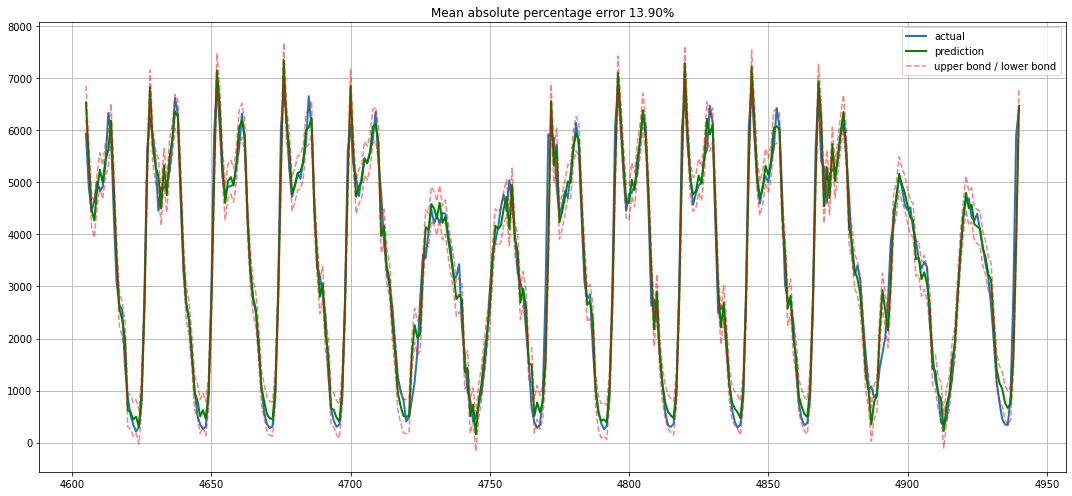

In [77]:
plotModelResults(lr, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)

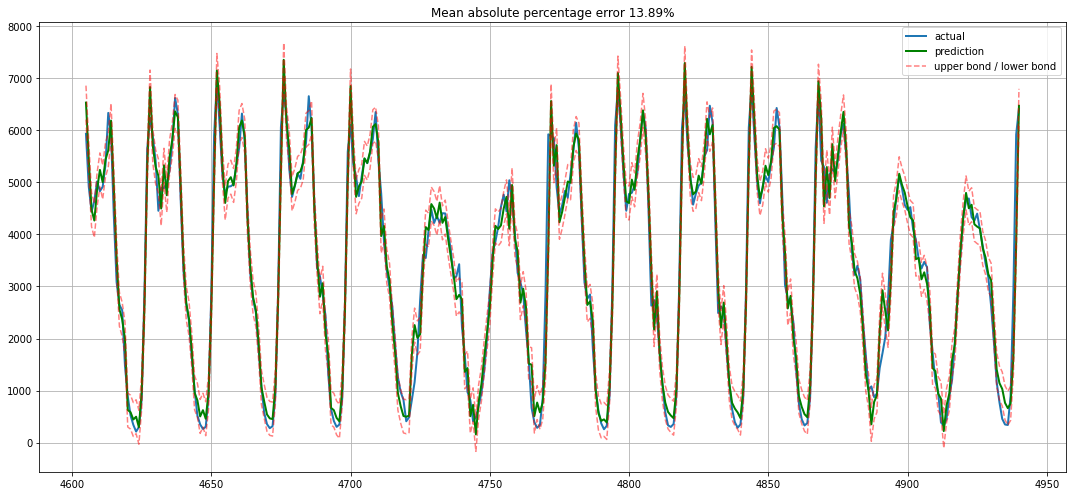

In [78]:
ridge = Ridge(random_state=4973)
ridge.fit(X_train, y_train)
plotModelResults(ridge, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, plot_intervals=True)

In [79]:
def recursive_predict(model, df_forecast,col_lags = 0):
    horizon = len(df_forecast)
    
    df_pred = df_forecast.copy()
    df_pred.iloc[1:,col_lags:] = np.nan
    
    forecast = []
    
    for i in range(horizon):
        next_x = model.predict(df_pred.iloc[[i], :])[0]
        if i < horizon-1:
            df_pred.iloc[i+1,col_lags] = next_x
            df_pred.iloc[[i+1],col_lags+1:] = df_pred.iloc[i,col_lags:-1].values
        forecast.append(next_x)
    
    return np.array(forecast)


def plotRecursivePrediction(model, X_test, y_test,col_lags):
    prediction = recursive_predict(model, X_test, col_lags)
    
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(prediction, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)

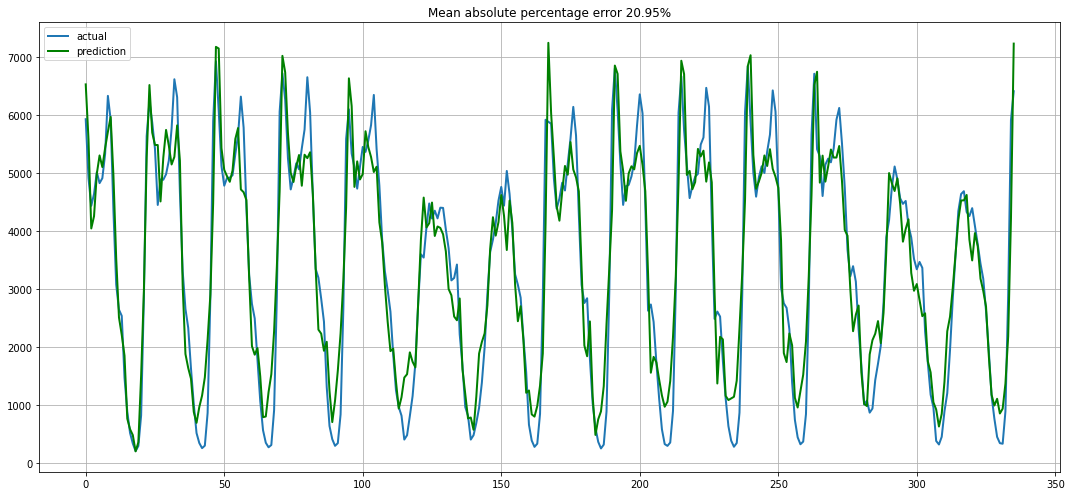

In [80]:
plotRecursivePrediction(lr, X_test, y_test,col_lag)

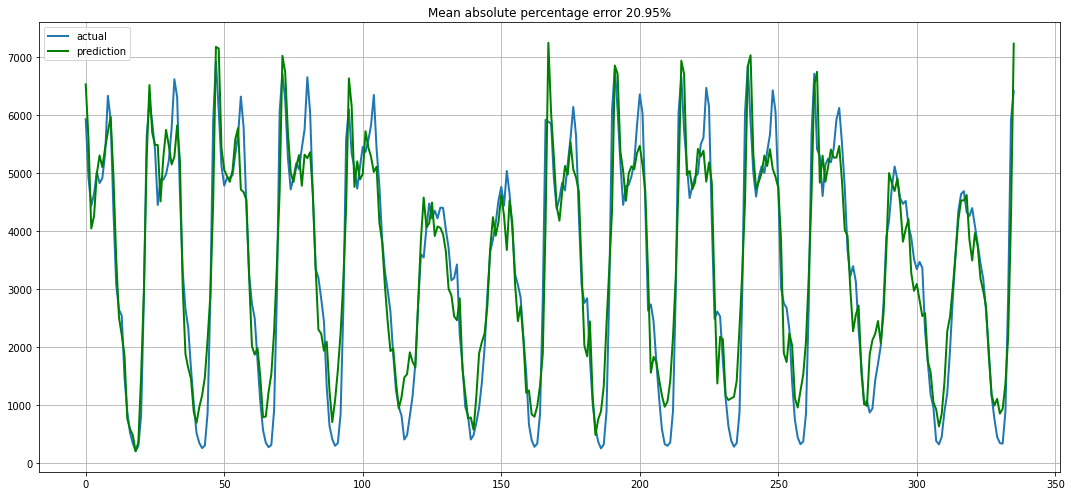

In [81]:
plotRecursivePrediction(ridge, X_test, y_test,col_lag)

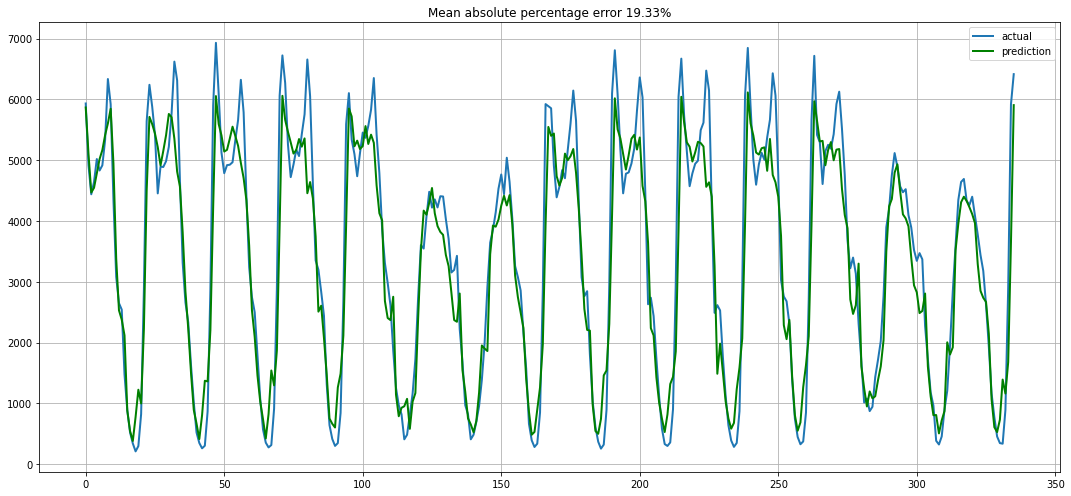

In [82]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

plotRecursivePrediction(gb, X_test, y_test,col_lag)

## 2.3 Простые модели с временными признаками

In [83]:
def create_time_features(data):
    data["hour"] = data.index.hour.values
    data['hour_cos'] = np.cos(2 * np.pi * data["hour"].values / 23)
    data['hour_sin'] = np.sin(2 * np.pi * data["hour"].values / 23)
    data["is_weekend"] = data.index.weekday.isin([5,6]).astype(int)
    return data


class MeanEncoder:
    def __init__(self, y_col, cat_feat):
        self.y_col = y_col
        self.cat_feat = cat_feat
        self.mean_codes = None
    
    def fit(self, data):
        cols = [self.y_col] + self.cat_feat
        self.mean_codes = data[cols].groupby(self.cat_feat).mean().to_dict()[self.y_col]
    
    def get_period_means(self, data):
        return data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def get_period_means_to_other(self, other_data):
        return other_data[self.cat_feat].apply(self._encode_with_mean, axis=1)
    
    def _encode_with_mean(self, row):
        key = tuple(row)
        val = self.mean_codes[key]
        return val


class LagEncoder:
    def __init__(self, start_lag, end_lag):
        self.start_lag = start_lag
        self.end_lag = end_lag
        self.lag_columns = []
        for i in range(self.start_lag, self.end_lag+1):
            col_name = "lag_{}".format(i)
            self.lag_columns.append(col_name)
    
    def get_lags(self, series):
        df_lags = pd.DataFrame(index=series.index)
        for i in range(self.start_lag, self.end_lag+1):
            col_name = self.lag_columns[i-1]
            df_lags[col_name] = series.shift(i)
        return df_lags

In [84]:
def prepare_data_from_1D_series(series, target='traffic_volume'):#, features = ['temp']):    
    df_series = pd.DataFrame(series)
    df_series.index = pd.to_datetime(df_series.index)

    df_lags = lag_encoder.get_lags(series)
    ## Здесь я могу вставить  нужные мне колонки от DF series !!! 
    # data = pd.concat([df_series, series[sfeatures],df_lags], axis=1)
    # firtst row should be 
    # df_series = pd.DataFrame(series[starget])
   
    data = pd.concat([df_series, df_lags], axis=1)
    
    
    data = create_time_features(data)

    mean_encoder.fit(data)
    data["mean_code"] = mean_encoder.get_period_means(data)

    data.dropna(inplace=True)
    
    ## Очень мне не нравиться что вообще все нормализуется!!! 
    ## все кроме таргета и лагов можно нормализовывать!!! 
    data.loc[:,:] = scaler.fit_transform(data)
    
    feat_cols = data.columns.tolist()
    feat_cols.remove(target)
    
    Y = data[target]
    X = data[feat_cols]
    
    forecast_start_X = data.loc[data.index[-1], [target]+lag_encoder.lag_columns[:-1]]    
    forecast_start_X.index = lag_encoder.lag_columns
    
    return X, Y,  target, feat_cols, forecast_start_X

In [85]:
print(['a','b']+[])

['a', 'b']


In [86]:
def create_forecast_timestamp(series, forecast_horizon):
    t2 = pd.to_datetime(series.index[-1])
    t1 = pd.to_datetime(series.index[-2])
    delta = t2 - t1
    t_index = [t2 + delta]
    for _ in range(forecast_horizon-1):
        t_index.append(t_index[-1] + delta)
    return t_index


def build_forecast_df(series,  target, feat_cols, forecast_start_X, forecast_horizon):
    t_index = create_forecast_timestamp(series, forecast_horizon=forecast_horizon)
    # print(t_index)
    forecast_df = pd.DataFrame(columns=[target]+feat_cols, index=t_index)

    forecast_df = create_time_features(forecast_df)
    forecast_df["mean_code"] = mean_encoder.get_period_means(forecast_df)
    
    forecast_df.iloc[:,:] = scaler.transform(forecast_df)

    forecast_df.loc[t_index[0], lag_encoder.lag_columns] = forecast_start_X.values
    return forecast_df


def recursive_predict(model, target,df_forecast):
    horizon = len(df_forecast)
    df_pred = df_forecast.copy()
    forecast = []
    lagcols = lag_encoder.lag_columns
    t = df_forecast.index
    
    feat_cols = df_forecast.columns.tolist()
    feat_cols.remove(target)
    
    for i in range(horizon):
        timestamp = t[i]
        next_x = model.predict(df_pred.loc[[timestamp], feat_cols])[0]
        if i < horizon-1:
            next_timestamp = t[i+1]
            df_pred.loc[next_timestamp, lagcols[0]] = next_x
            df_pred.loc[next_timestamp, lagcols[1:]] = df_pred.loc[timestamp, lagcols[:-1]].values
        forecast.append(next_x)
    
    df_pred.loc[:, target] = forecast
    df_pred.loc[:,:] = scaler.inverse_transform(df_pred)
    return df_pred


def plotRecursivePrediction(y_test, y_forecast):
    plt.figure(figsize=(15, 7))
    
    error = mean_absolute_percentage_error(y_forecast.values, y_test.values)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(y_forecast.values, "g", label="prediction", linewidth=2.0)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True)


def plotCoefficients(model, X_train):
    """
    Plots sorted coefficient values of the model
    """
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [87]:
target='traffic_volume'
series_train, series_test = timeseries_train_test_split(short_data.iloc[:5000,1], test_size=0.3)

mean_encoder = MeanEncoder(y_col=target, cat_feat=["hour", "is_weekend"])
scaler = StandardScaler()
lag_encoder = LagEncoder(start_lag=1, end_lag=30)

In [88]:
X_train, y_train, target, feat_cols, forecast_start_X = prepare_data_from_1D_series(series_train)

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [89]:

df_forecast = build_forecast_df(series_train, target,feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(lr, target, df_forecast)

# 

In [90]:
series_test.head()

date_time
2016-05-09 08:00:00    5932.0
2016-05-09 09:00:00    4917.0
2016-05-09 10:00:00    4439.0
2016-05-09 11:00:00    4643.0
2016-05-09 12:00:00    5019.0
Name: traffic_volume, dtype: float64

In [91]:
df_forecasted.head()

,traffic_volume,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_26,lag_27,lag_28,lag_29,lag_30,hour,hour_cos,hour_sin,is_weekend,mean_code
2016-05-09 08:00:00,6297.719457,6874.012446,5900.875949,2780.407678,853.627151,304.009352,264.254605,351.383768,596.586116,1144.506863,...,1036.934623,599.074683,367.111610,419.944098,629.922769,8.0,-0.576680,0.816970,0.0,5536.520531
2016-05-09 09:00:00,5572.684205,6295.930959,6872.872466,5900.918365,2780.219644,853.635316,304.261657,264.645867,352.001603,597.152011,...,1623.444432,1037.001531,599.180313,367.055012,419.862937,9.0,-0.775711,0.631088,0.0,4943.111111
2016-05-09 10:00:00,4773.842883,5571.145278,6294.800452,6873.112635,5901.029705,2780.223646,853.856028,304.649463,265.274949,352.593873,...,2098.053190,1623.500928,1037.095877,599.126769,366.972861,10.0,-0.917211,0.398401,0.0,4530.502415
2016-05-09 11:00:00,4342.258663,4772.578934,5570.026649,6294.923012,6873.317244,5901.026966,2780.333619,854.196355,305.273358,265.876571,...,3105.587338,2098.101260,1623.580162,1037.048098,599.048961,11.0,-0.990686,0.136167,0.0,4678.937198
2016-05-09 12:00:00,4419.360477,4341.143273,4771.473391,5570.001754,6295.072151,6873.312405,5900.957555,2780.507517,854.748992,305.870666,...,3859.087924,3105.617521,2098.168265,1623.540102,1036.978483,12.0,-0.990686,-0.136167,0.0,4919.532609


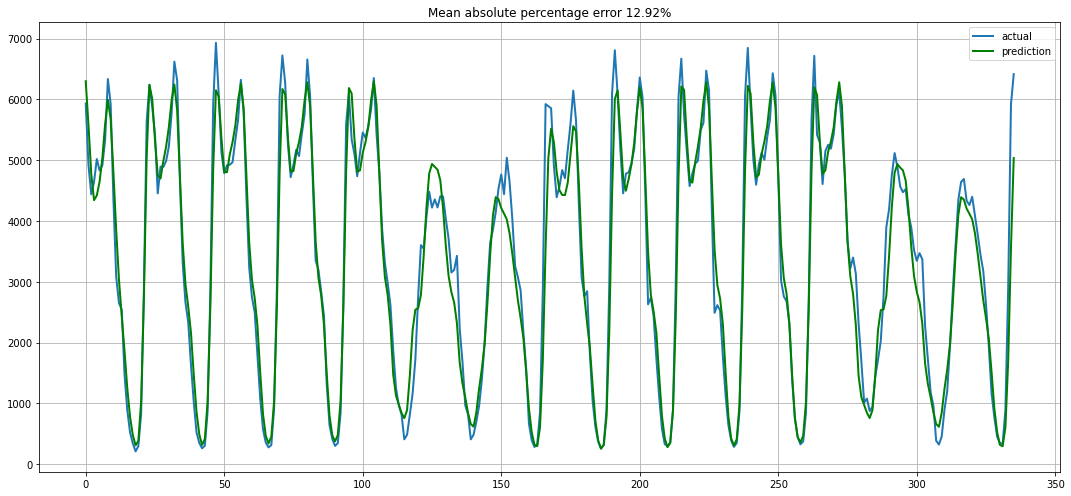

In [92]:
plotRecursivePrediction(series_test, df_forecasted[target])

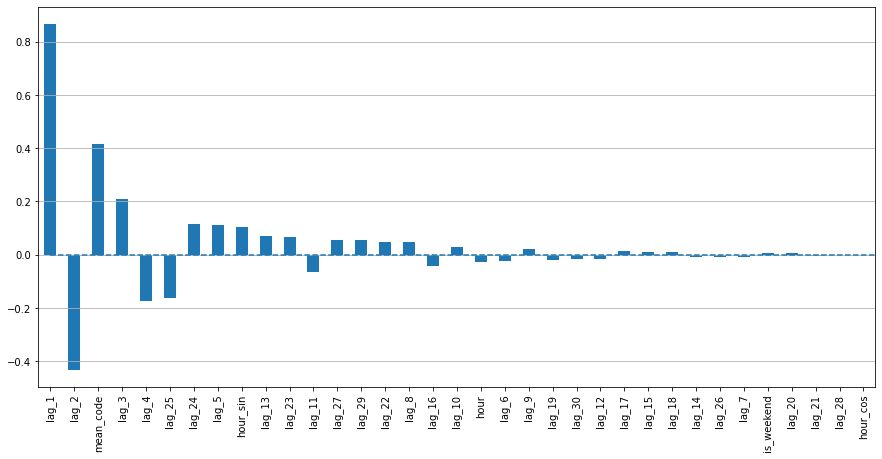

In [93]:
plotCoefficients(lr, X_train)

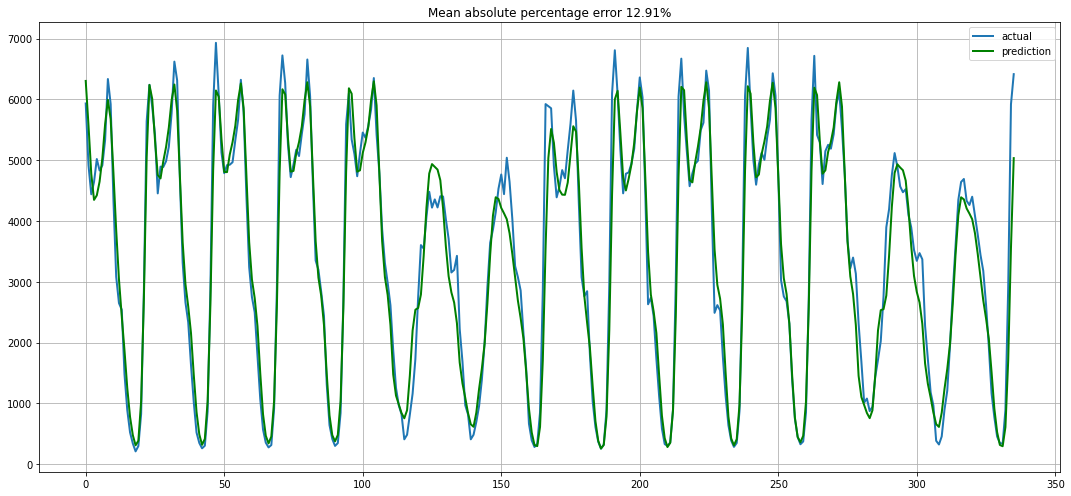

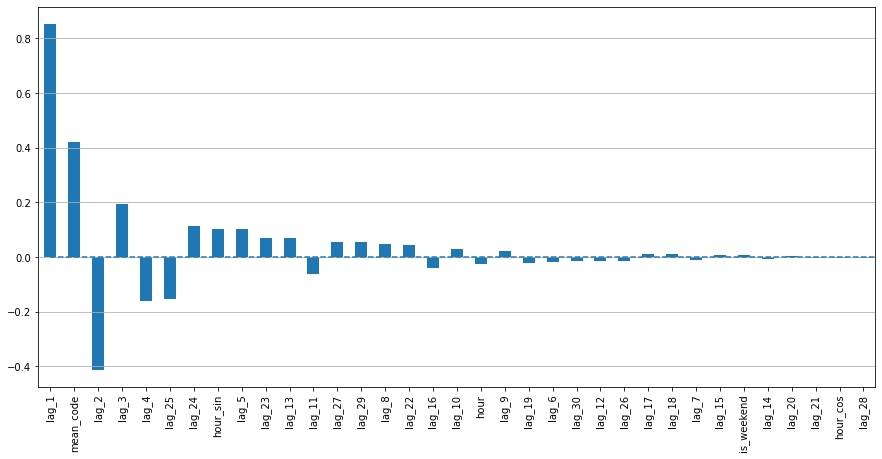

In [94]:
tscv = TimeSeriesSplit(n_splits=5)
ridge = RidgeCV(cv=tscv, alphas=np.linspace(0.1, 10, 100))
ridge.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target, feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(ridge, target,df_forecast)

plotRecursivePrediction(series_test, df_forecasted[target])
plotCoefficients(ridge, X_train)

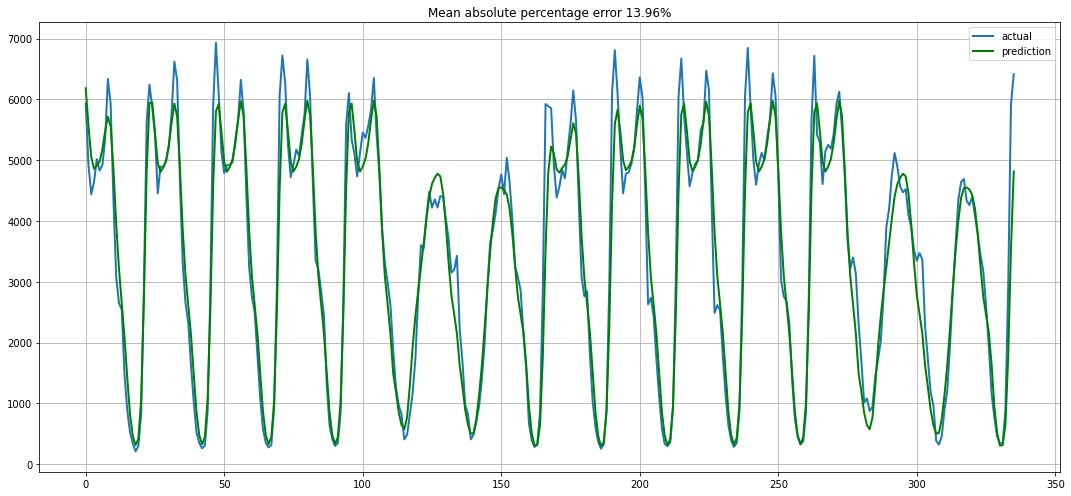

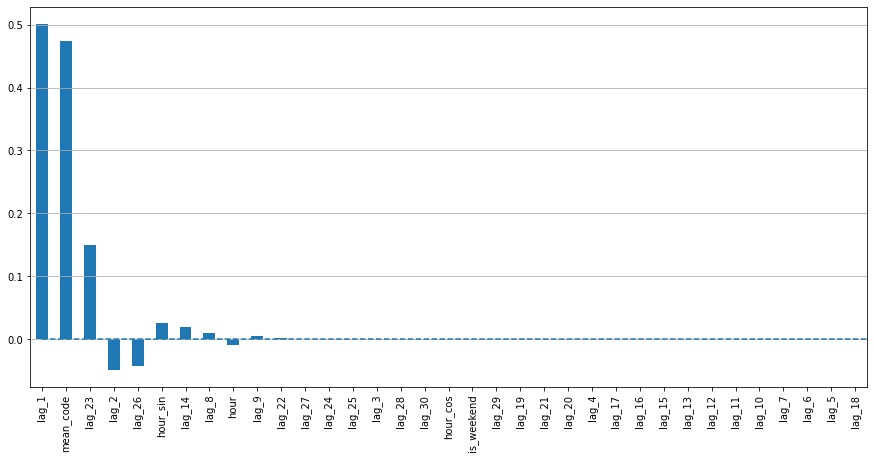

In [95]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target, feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(lasso, target,df_forecast)

plotRecursivePrediction(series_test, df_forecasted[target])
plotCoefficients(lasso, X_train)

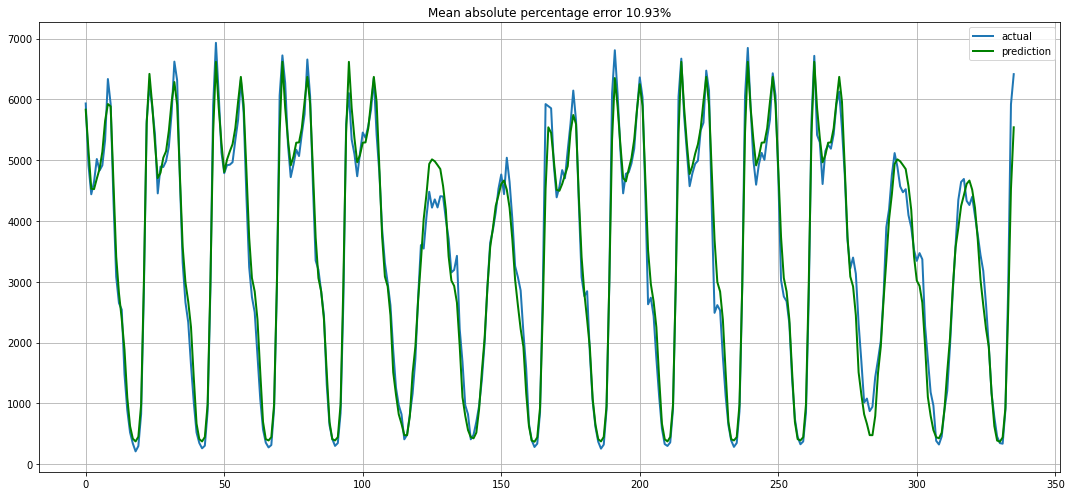

In [96]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

df_forecast = build_forecast_df(series_train, target,feat_cols, forecast_start_X, forecast_horizon=len(series_test))
df_forecasted = recursive_predict(gb, target,df_forecast)

plotRecursivePrediction(series_test, df_forecasted[target])

In [108]:
def get_base_line_mape(y_test,y_train,target):
    if (len(y_train)<len(y_test)):
        print("This: len(y_train)<len(y_test) is wrong!!!")
        return -1
    df_test = pd.DataFrame(y_test)
    
    df_train = pd.DataFrame(y_train)
    # print(df_test.head())
    # print(df_train.head())
    df_test = create_time_features(df_test)
    df_train = create_time_features(df_train)
    # print(df_test.head())
    # print(df_train.head())
    
    mean_encoder.fit(df_train)
    # mean_encoder.fit(df_test)
    # def get_period_means_to_other(self, other_data, other):
    #     return other_data[other.cat_feat].apply(self._encode_with_mean, axis=1)
    df_test["mean_code"] = mean_encoder.get_period_means_to_other(df_test)
    # print(df_test.head())
    # print(df_train.head())
    # df_series.groupby(["weekday", "hour"])["traffic_volume"].mean()
    # print(df_test)
    MAPE = mean_absolute_percentage_error(df_test[target], df_test["mean_code"])
    print(f"MAE = {MAPE}")
    return MAPE

In [109]:
 base_line_mape = get_base_line_mape(series_test,series_train,target)

MAE = 11.373328542342353


In [110]:
print(base_line_mape)

11.373328542342353


# 4 Результаты сравнения моделей

In [100]:
14*24

336

In [101]:
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})

In [102]:
df

,Animal,Max Speed
0,Falcon,380.0
1,Falcon,370.0
2,Parrot,24.0
3,Parrot,26.0


In [103]:
df.loc[df.index[-1],['Max Speed']+['Animal']]

Max Speed      26.0
Animal       Parrot
Name: 3, dtype: object

In [104]:
data.loc[data.index[-1],[target] + lag_encoder.lag_columns[:-1]]

KeyError: "['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29'] not in index"

In [ ]:
df.groupby(["Animal"]).mean()

In [ ]:
df.groupby(["Animal"]).mean().to_dict()

In [ ]:
df.groupby(["Animal"]).mean().to_dict()['Max Speed']